실습 목표

 * 영상 데이터를 불러오는 방법을 안다.
 * 딥러닝 모델의 층을 쌓는 방법을 안다.
 * 모델을 학습하는 방법과 학습한 모델을 평가하는 방법을 안다.
 * 이론으로 배운 개념이 어디에 적용되는지 확인한다.

목차

 * I. 입출력 데이터 처리
   1. 데이터 세트 불러오기
   2. 데이터 전처리
     1. 데이터 크기 조정하기
     2. 데이터 셔플
 * II. 커스텀 모델 학습 및 평가
   5. 모델 빌드 및 컴파일
   6. 모델 학습
   7. 모델 평가
 * III. CNN 모델 학습 및 평가
   5. 모델 빌드 및 컴파일
   6. 모델 학습
   7. 모델 평가

In [2]:
import os, random

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf

2025-08-29 04:32:09.853514: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-29 04:32:14.414799: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 04:32:20.370824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# 데이터 저장 경로
DATA_DIR = './chest_xray_dataset'

# 클래스 정보
labels = ['NORMAL', 'PNEUMONIA']

# I. 입출력 데이터 처리

## 1. 데이터 세트 불러오기

폐렴 환자와 정상인으로부터 수집한 X선 이미지 (출처: [kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia))

### 1) 데이터 하나만 읽어보기

python의 `opencv`라는 라이브러리를 활용하여 다양한 컴퓨터 비전 관련 처리를 수행할 수 있음

In [5]:
data_path = os.path.join(DATA_DIR, 'val', 'PNEUMONIA', 'person1951_bacteria_4882.jpeg')
data_path

'./chest_xray_dataset/val/PNEUMONIA/person1951_bacteria_4882.jpeg'

`cv2.imread()` 메서드를 사용하면 이미지 데이터(jpeg, png, tiff, ...)를 읽어올 수 있음.

In [6]:
img = cv2.imread(data_path)
img.shape, img.min(), img.max()

((656, 1016, 3), np.uint8(0), np.uint8(255))

영상 데이터는 (세로, 가로, 채널) 형태의 shape을 가지며, 이 데이터는 RGB 색공간을 가져 0에서 255 사이의 값을 가지는 것을 알 수 있음

그렇다면 이미지 데이터는 어떻게 생겼을까?

In [7]:
img

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 6,  6,  6],
        [ 6,  6,  6],
        [ 6,  6,  6]],

       ...,

       [[ 0,  0,  0],
        [ 1,  1,  1],
        [ 0,  0,  0],
        ...,
        [ 9,  9,  9],
        [ 8,  8,  8],
        [ 0,  0,  0]],

       [[ 4,  4,  4],
        [ 1,  1,  1],
        [ 7,  7,  7],
        ...,
        [15, 15, 15],
        [ 7,  7,  7],
        [10, 10, 10]],

       [[ 8,  8,  8],
        [ 0,  0,  0],
        [17, 17, 17],
        ...,
        [20, 20, 20],
        [ 0,  0,  0],
        [18, 18, 18]]], shape=(656, 1016, 3), dtype=uint8)

이미지 데이터를 더블클릭했을 때처럼 보고 싶은데?

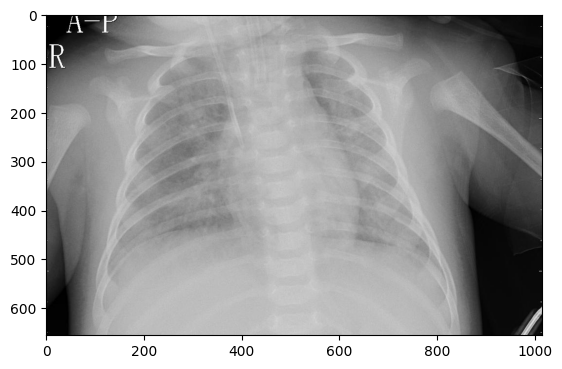

In [8]:
plt.imshow(img)
plt.show()

세균성 폐렴 환자의 폐 X선 영상

### 2) 활용할 수 있는 이미지를 모두 읽어서 변수에 저장하기

In [9]:
def get_data(dataset_dir):
    imgs = []
    diagnoses = []
    for label in labels:
        label_dir = os.path.join(dataset_dir, label)
        jpeg_files = [f for f in os.listdir(label_dir) if f.lower().endswith('.jpeg')]
        jpeg_files = sorted(jpeg_files)[:100]  # 최대 100개만 사용
        for fname in tqdm(jpeg_files, desc=f'Loading {label}'):
            img_path = os.path.join(label_dir, fname)
            img = cv2.imread(img_path)
            if img is not None:
                imgs.append(img)
                diagnoses.append(label)
    return imgs, diagnoses

In [10]:
img_train, diagnoses_train = get_data(os.path.join(DATA_DIR, 'train'))
img_val, diagnoses_val = get_data(os.path.join(DATA_DIR, 'val'))
img_test, diagnoses_test = get_data(os.path.join(DATA_DIR, 'test'))

len(img_train), len(diagnoses_train), len(img_val), len(diagnoses_val), len(img_test), len(diagnoses_test)

Loading NORMAL:   0%|          | 0/100 [00:00<?, ?it/s]

Loading PNEUMONIA: 100%|██████████| 100/100 [00:00<00:00, 182.80it/s]


(200, 200, 16, 16, 200, 200)

img_{dataset}에는 폐영상을, diagnosis_{dataset}에는 폐렴/정상에 대한 정보를 리스트 형태로 저장함. 학습/검증/평가 데이터 세트에는 폐렴/정상 데이터가 몇 개씩 있을지 확인해보자.

In [11]:
np.unique(diagnoses_train, return_counts=True),\
np.unique(diagnoses_val, return_counts=True),\
np.unique(diagnoses_test, return_counts=True)

((array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([100, 100])),
 (array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([8, 8])),
 (array(['NORMAL', 'PNEUMONIA'], dtype='<U9'), array([100, 100])))

데이터 세트에 따른 폐렴과 정상 환자의 이미지 개수는?

 * 학습 데이터 세트(200): 정상-100, 폐렴-100 (원래, 정상-1341, 폐렴-3875)
 * 검증 데이터 세트(16): 정상-8, 폐렴-8
 * 테스트 데이터 세트(200): 정상-100, 폐렴-100

### 3) 데이터 시각화

`plt.imshow()`라는 메서드를 활용하여, 이미지 데이터를 숫자 -> 색으로 변환하여 시각적으로 확인할 수 있다.

(1858, 2090, 3)


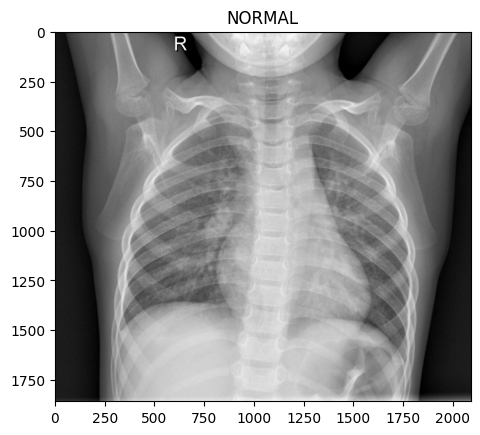

In [12]:
print(img_train[0].shape)
plt.imshow(img_train[0])
plt.title(diagnoses_train[0])
plt.show()

데이터 세트의 데이터를 하나씩 꺼내와서 시각화하고, 어떤 환자인지, 이미지의 크기는 어떤지 같이 확인해보자

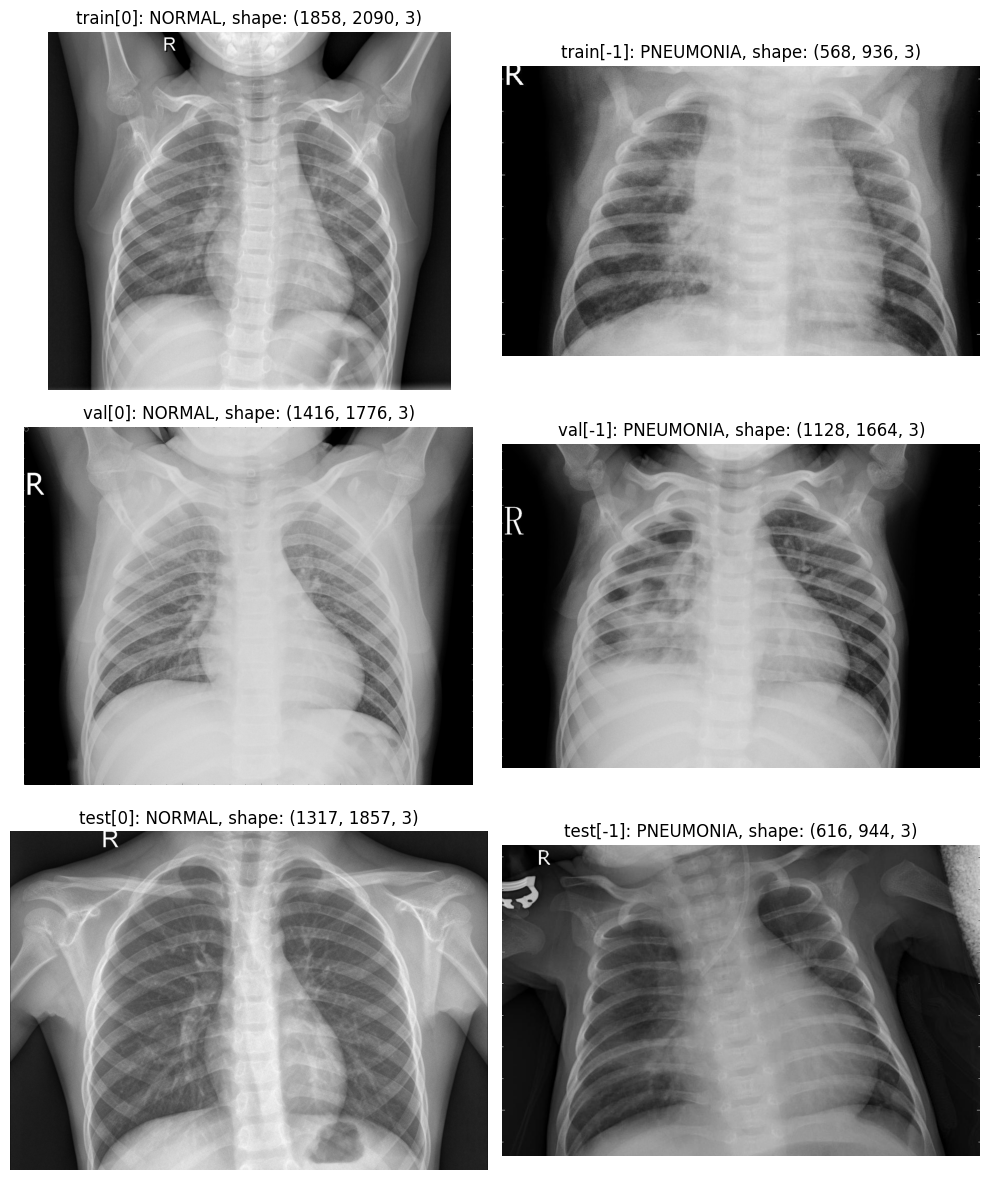

In [13]:
plt.figure(figsize=(10, 12))

# 학습 데이터 첫/마지막
plt.subplot(3, 2, 1)
plt.imshow(img_train[0])
plt.title(f"train[0]: {diagnoses_train[0]}, shape: {img_train[0].shape}")
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(img_train[-1])
plt.title(f"train[-1]: {diagnoses_train[-1]}, shape: {img_train[-1].shape}")
plt.axis('off')

# 검증 데이터 첫/마지막
plt.subplot(3, 2, 3)
plt.imshow(img_val[0])
plt.title(f"val[0]: {diagnoses_val[0]}, shape: {img_val[0].shape}")
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(img_val[-1])
plt.title(f"val[-1]: {diagnoses_val[-1]}, shape: {img_val[-1].shape}")
plt.axis('off')

# 테스트 데이터 첫/마지막
plt.subplot(3, 2, 5)
plt.imshow(img_test[0])
plt.title(f"test[0]: {diagnoses_test[0]}, shape: {img_test[0].shape}")
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(img_test[-1])
plt.title(f"test[-1]: {diagnoses_test[-1]}, shape: {img_test[-1].shape}")
plt.axis('off')

plt.tight_layout()
plt.show()

첫째 줄이 학습 데이터 세트, 둘째 줄이 검증 데이터 세트, 셋째 줄이 평가 데이터 세트인데, 데이터마다 크기와 비율이 제각각임을 알 수 있음

## 2. 데이터 전처리

### 1) 데이터 크기 조정

위 shape과 시각화 결과를 통해 데이터마다 크기가 다름을 확인함. 인공지능의 입력 데이터는 같은 크기를 가져야 함. 따라서 단일한 크기로 조정함. 영상의 크기는 다양하게 조절 가능한데, 오늘은 원활한 학습을 위해 작은 크기로 줄임

In [14]:
IMG_SHAPE = (224, 224, 3)

데이터 크기 조정해보기

(1858, 2090, 3)


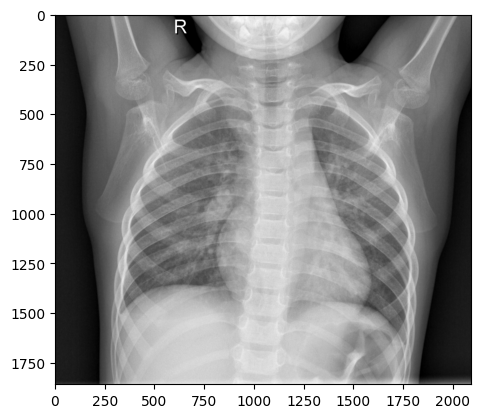

In [15]:
print(img_train[0].shape)
plt.imshow(img_train[0])
plt.show()

In [ ]:
resized_img = cv2.resize(img, dsize=IMG_SHAPE[:2])
print("Resized image shape:", resized_img.shape)
plt.imshow(resized_img)
plt.title(f"Resized to {IMG_SHAPE}")
plt.axis('off')
plt.show()

(224, 224, 3)


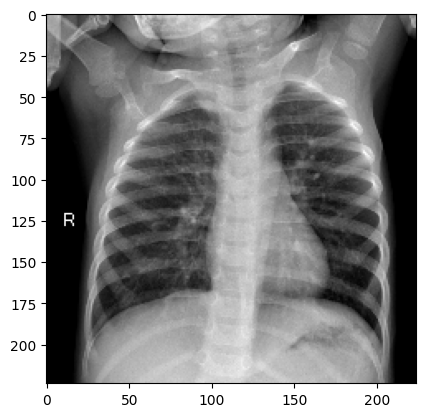

In [16]:
resized_img = cv2.resize(img_train[0], dsize=IMG_SHAPE[:2])
print(resized_img.shape)
plt.imshow(resized_img)
plt.show()

`cv2.resize(img, dsize)` 메서드를 사용하여 이미지의 크기를 원하는 크기로 조정할 수 있음. `interpolation=`은 영상의 크기를 조절하는 방식을 지정하는 파라미터로, 이미지의 크기를 줄일 때에는 주로 영역보간법(`INTER_AREA`)을 활용함

In [17]:
img_train = np.array([cv2.resize(img, dsize=IMG_SHAPE[:2], interpolation=cv2.INTER_AREA) for img in tqdm(img_train)])
img_val = np.array([cv2.resize(img, dsize=IMG_SHAPE[:2], interpolation=cv2.INTER_AREA) for img in tqdm(img_val)])
img_test = np.array([cv2.resize(img, dsize=IMG_SHAPE[:2], interpolation=cv2.INTER_AREA) for img in tqdm(img_test)])

img_train.shape, img_val.shape, img_test.shape

100%|██████████| 624/624 [00:04<00:00, 129.90it/s]


((1200, 224, 224, 3), (16, 224, 224, 3), (624, 224, 224, 3))

In [18]:
diagnosis_train = np.array(diagnosis_train)
diagnosis_val = np.array(diagnosis_val)
diagnosis_test = np.array(diagnosis_test)

diagnosis_train.shape, diagnosis_val.shape, diagnosis_test.shape

((1200,), (16,), (624,))

In [19]:
img_train.shape, diagnosis_train.shape

((1200, 224, 224, 3), (1200,))

### 2) 데이터 셔플

현재 모든 데이터 세트의 데이터는 클래스 순서대로 구성됨. 이러한 데이터로 학습 시 모델에 편향이 발생할 수 있음. 데이터를 무작위로 섞는 셔플을 적용하여, 데이터에 있는 순서를 제거하자.

In [20]:
diagnosis_train #, diagnosis_val, diagnosis_test

array(['NORMAL', 'NORMAL', 'NORMAL', ..., 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA'], dtype='<U9')

In [21]:
def shuffle_data(imgs, diagnosis):

    # 인덱스 셔플
    shuffled_index = np.random.choice(diagnosis.shape[0], diagnosis.shape[0], replace=False) #np.random.shuffle(index)

    # 데이터 셔플
    shuffled_imgs = imgs[shuffled_index]
    shuffled_diagnosis = diagnosis[shuffled_index]

    return shuffled_imgs, shuffled_diagnosis

In [22]:
img_train, diagnosis_train = shuffle_data(img_train, diagnosis_train)
img_val, diagnosis_val = shuffle_data(img_val, diagnosis_val)
img_test, diagnosis_test = shuffle_data(img_test, diagnosis_test)

In [23]:
diagnosis_train

array(['PNEUMONIA', 'PNEUMONIA', 'NORMAL', ..., 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA'], dtype='<U9')

### 3) 전처리가 끝난 데이터는?

In [24]:
img_train.shape, diagnosis_train.shape

((1200, 224, 224, 3), (1200,))

In [25]:
img_val.shape, diagnosis_val.shape

((16, 224, 224, 3), (16,))

In [26]:
img_test.shape, diagnosis_test.shape

((624, 224, 224, 3), (624,))

# II. 커스텀 모델 학습 및 평가

## 5. 커스텀 모델 빌드 및 컴파일

학습할 모델을 쌓고(빌드), 쌓은 모델의 학습에 사용할 loss function, optimizer를 지정하여 컴파일한다.

### 1) 커스텀 모델 빌드

In [27]:
def build_custom_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_shape[:2]))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 분류 문제

    return model

In [28]:
model = build_custom_model(IMG_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dense_1 (Dense)             (None, 64)                65600     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51446913 (196.25 MB)
Trainable params: 51446913 (196.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2) 커스텀 모델 컴파일

하이퍼 파라미터 설정 (vs. 파라미터)

In [29]:
EPOCHS = 50
BATCH_SIZE = 30 ## 1200/30=40번 만에 1에폭을 학습할 것
LEARNING_RATE = 0.001

In [30]:
# define optimizer
adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # 최적화 알고리즘에 학습률 전달

# compile model
model.compile(optimizer=adam, # 최적화 알고리즘: adam
             loss='binary_crossentropy', # 손실 함수: binary_crossentropy
             metrics=['accuracy'], # 정확도 계산
             )

## 6. 모델 학습

### 1) 입출력 데이터 선언

In [31]:
model.input

<KerasTensor: shape=(None, 224, 224) dtype=float32 (created by layer 'flatten_input')>

In [32]:
img_train.shape, img_val.shape, img_test.shape

((1200, 224, 224, 3), (16, 224, 224, 3), (624, 224, 224, 3))

In [33]:
X_train = np.array([x[:,:,0] for x in img_train])
X_val = np.array([x[:,:,0] for x in img_val])
X_test = np.array([x[:,:,0] for x in img_test])

X_train.shape, X_val.shape, X_test.shape

((1200, 224, 224), (16, 224, 224), (624, 224, 224))

커스텀 모델의 입출력은 2차원 이미지임.

In [34]:
y_train = np.squeeze(np.where(diagnosis_train == labels[0], 0, 1))
y_val = np.squeeze(np.where(diagnosis_val == labels[0], 0, 1))
y_test = np.squeeze(np.where(diagnosis_test == labels[0], 0, 1))

y_train.shape, y_val.shape, y_test.shape, y_train[0]

((1200,), (16,), (624,), 1)

### 2) 모델 학습

`model.fit()`을 통해 모델 학습을 수행할 수 있음

In [35]:
# model training

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
40/40 [==============================] - 4s 23ms/step - loss: 1430.1400 - accuracy: 0.7033 - val_loss: 205.9462 - val_accuracy: 0.6875
Epoch 2/50
40/40 [==============================] - 1s 16ms/step - loss: 145.8280 - accuracy: 0.8300 - val_loss: 301.5013 - val_accuracy: 0.6250
Epoch 3/50
40/40 [==============================] - 1s 16ms/step - loss: 51.4851 - accuracy: 0.9108 - val_loss: 68.0235 - val_accuracy: 0.8750
Epoch 4/50
40/40 [==============================] - 1s 16ms/step - loss: 112.8419 - accuracy: 0.8750 - val_loss: 355.0068 - val_accuracy: 0.5000
Epoch 5/50
40/40 [==============================] - 1s 16ms/step - loss: 130.6621 - accuracy: 0.8608 - val_loss: 715.3129 - val_accuracy: 0.5000
Epoch 6/50
40/40 [==============================] - 1s 18ms/step - loss: 196.6639 - accuracy: 0.8417 - val_loss: 90.0504 - val_accuracy: 0.9375
Epoch 7/50
40/40 [==============================] - 1s 19ms/step - loss: 36.0831 - accuracy: 0.9517 - val_loss: 37.6234 - val_accura

### 3) Learning curve 확인하기

학습이 잘 수행되었다면, 실제 데이터와 예측 결과 데이터의 손실이 학습이 진행됨에 따라 줄어들어야 함.

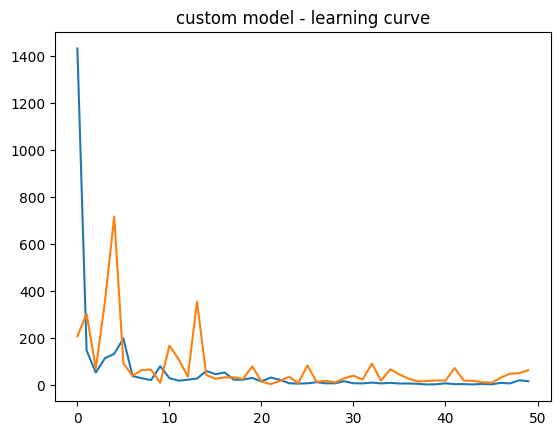

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('custom model - learning curve')
plt.show()

## 7. 모델 평가하기

모델이 잘 만들어졌는지 평가 데이터로 확인

### 1) 정확도 계산하기

학습이 잘 수행되었는지 확인하기 위해서는 평가 데이터를 통해 정확도를 계산해야 함. 정확도는 다음과 같음.

> Accuracy(%) = (제대로 예측된 데이터의 개수) / (전체 데이터 개수) * 100

In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=1)

38/38 [==============================] - 0s 6ms/step - loss: 19.6795 - accuracy: 0.9017


학습하지 않은 데이터에 대해서도 약 80%의 정확도로 폐렴을 잘 알아맞추는 것을 알 수 있음. 학습이나 검증에 사용한 데이터에 대해서도 정확도를 구할 수 있음.

### 2) 혼동 행렬(Confusion Matrix) 나타내기

혼동 행렬은 지도 학습으로 훈련된 분류 알고리즘의 성능을 시각화하는 방법으로, 모델이 예측을 잘 수행하였는지를 파악할 수 있음

In [38]:
y_pred = model.predict(X_test)
y_pred.shape, y_pred[0]

20/20 [==============================] - 0s 5ms/step


((624, 1), array([1.], dtype=float32))

예측 결과를 차트로 그려보자

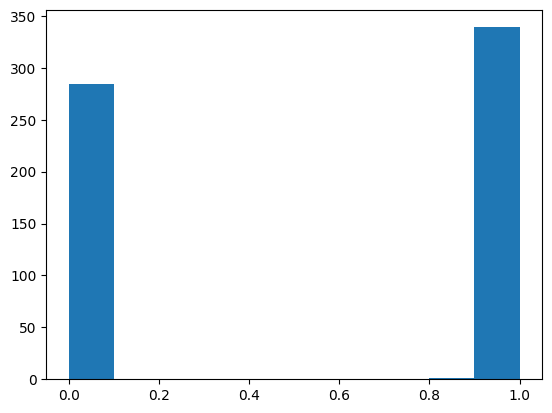

In [39]:
plt.hist(y_pred)
plt.show()

시그모이드 함수를 사용하였으므로, 결과가 0~1 사이의 값으로 나옴. 0.5보다 작으면 0, 크면 1로 변환하여 맞췄는지 틀렸는지를 확인해보자

In [40]:
y_pred = np.squeeze([int(x >= 0.5) for x in np.squeeze(y_pred)])
y_pred.shape, y_pred[0]

((624,), 1)

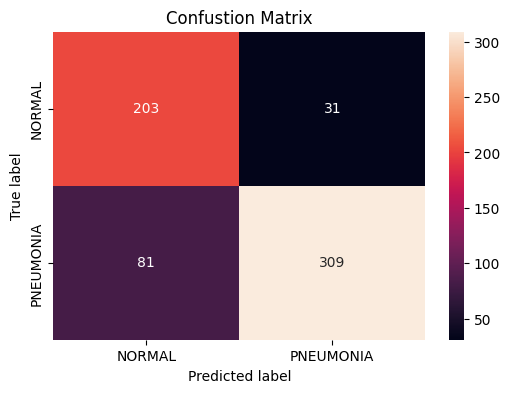

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confustion Matrix")
plt.show()

# III. CNN 모델 학습 및 평가 (DenseNet121)

## 5. 모델 빌드 및 컴파일

학습할 모델을 쌓고(빌드), 쌓은 모델의 학습에 사용할 loss function, optimizer를 지정하여 컴파일한다.

### 1) DenseNet121 아키텍처 파인 튜닝 (fine tuning)

In [42]:
def build_pretrained_densenet121_model(input_shape):

    # architecture construction
    ### based on DenseNet121
    ### pretrained by imagenet

    # load basemodel
    baseModel = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg',
    )

    # construct the model that will be placed on bottom of the base model
    headModel = tf.keras.layers.Dropout(0.5)(baseModel.output)
    headModel = tf.keras.layers.Dense(1, activation="sigmoid")(headModel)

    # place the head FC model on bottom of the base model
    model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

    return model

In [43]:
model = build_pretrained_densenet121_model(IMG_SHAPE)
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

### 2) 모델 컴파일

In [44]:
EPOCHS = 50
BATCH_SIZE = 30
LEARNING_RATE = 0.00001

In [45]:
# define optimizer
adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile model
model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'],
             )

## 6. 모델 학습

### 1) 입출력 데이터 선언

In [46]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

CNN 모델의 입력은 3D 이미지임

In [47]:
X_train, X_val, X_test = img_train, img_val, img_test

X_train.shape, X_val.shape, X_test.shape

((1200, 224, 224, 3), (16, 224, 224, 3), (624, 224, 224, 3))

In [48]:
y_train = np.squeeze(np.where(diagnosis_train == labels[0], 0, 1))
y_val = np.squeeze(np.where(diagnosis_val == labels[0], 0, 1))
y_test = np.squeeze(np.where(diagnosis_test == labels[0], 0, 1))

y_train.shape, y_val.shape, y_test.shape, y_train[0]

((1200,), (16,), (624,), 1)

### 2) 모델 학습

하이퍼 파라미터 설정

`model.fit()`을 통해 모델 학습을 수행할 수 있음

In [49]:
# model training

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
)

Epoch 1/50
40/40 [==============================] - 92s 487ms/step - loss: 0.5512 - accuracy: 0.6875 - val_loss: 0.5173 - val_accuracy: 0.7500
Epoch 2/50
40/40 [==============================] - 12s 310ms/step - loss: 0.2473 - accuracy: 0.8983 - val_loss: 0.3855 - val_accuracy: 0.8750
Epoch 3/50
40/40 [==============================] - 12s 311ms/step - loss: 0.1838 - accuracy: 0.9400 - val_loss: 0.3009 - val_accuracy: 0.9375
Epoch 4/50
40/40 [==============================] - 13s 313ms/step - loss: 0.1182 - accuracy: 0.9633 - val_loss: 0.2238 - val_accuracy: 0.9375
Epoch 5/50
40/40 [==============================] - 13s 314ms/step - loss: 0.0985 - accuracy: 0.9700 - val_loss: 0.1788 - val_accuracy: 0.9375
Epoch 6/50
40/40 [==============================] - 13s 316ms/step - loss: 0.0811 - accuracy: 0.9758 - val_loss: 0.1748 - val_accuracy: 0.9375
Epoch 7/50
40/40 [==============================] - 13s 318ms/step - loss: 0.0794 - accuracy: 0.9725 - val_loss: 0.1407 - val_accuracy: 1.0000

### 3) Learning curve 확인하기

학습이 잘 수행되었다면, 실제 데이터와 예측 결과 데이터의 손실이 학습이 진행됨에 따라 줄어들어야 함.

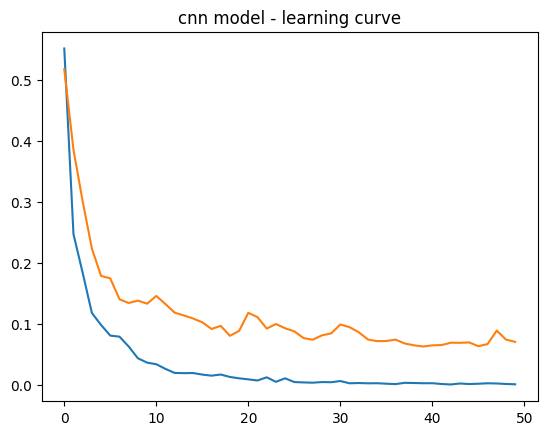

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn model - learning curve')
plt.show()

## 7. 모델 평가하기

모델이 잘 만들어졌는지 평가 데이터로 확인

### 1) 정확도 계산하기

학습이 잘 수행되었는지 확인하기 위해서는 평가 데이터를 통해 정확도를 계산해야 함. 정확도는 다음과 같음.

> Accuracy(%) = (제대로 예측된 데이터의 개수) / (전체 데이터 개수) * 100

In [51]:
model.evaluate(X_test, y_test, verbose=1)
model.evaluate(X_val, y_val, verbose=1)
model.evaluate(X_train, y_train, verbose=1)

38/38 [==============================] - 3s 84ms/step - loss: 2.0751e-04 - accuracy: 1.0000


[0.00020751319243572652, 1.0]

학습하지 않은 데이터에 대해서도 약 82%의 정확도로 폐렴을 잘 알아맞추는 것을 알 수 있음.

### 2) 혼동 행렬(Confusion Matrix) 나타내기

In [52]:
y_pred = model.predict(X_test)
y_pred.shape, y_pred[0]

20/20 [==============================] - 3s 85ms/step


((624, 1), array([0.99999774], dtype=float32))

In [53]:
y_pred = np.squeeze([int(x >= 0.5) for x in np.squeeze(y_pred)])
y_pred.shape, y_pred[0]

((624,), 1)

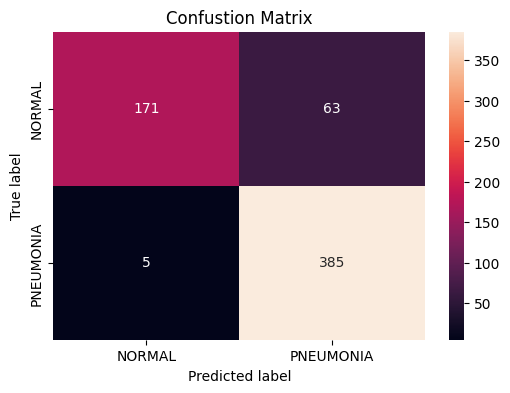

In [54]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confustion Matrix")
plt.show()

# 마무리
 * Q. 직접 만든 모델의 성능과 영상 처리 특화 모델의 성능은 어떻게 다른가요?
 * Q. 성능이 높으면 좋은 모델이라고 할 수 있을까요?

실습 목표

 * 영상 데이터를 불러오는 방법을 안다. => `cv2.imread()`
 * 딥러닝 모델의 층을 쌓는 방법을 안다. => `model.add([layers])`
 * 모델을 학습하는 방법과 학습한 모델을 평가하는 방법을 안다. => `model.fit()`, `model.evaluate()`
 * 이론으로 배운 개념이 어디에 적용되는지 확인한다. => node, layer, activation, optimizer, loss function, loss, learning_rate 등...


우리는 오늘..
 * 폐렴 X-ray 공개 데이터셋을 활용하여
 * 폐렴 여부를 분류하는
 * 딥러닝 모델을 만들고 학습하고 평가하였으며,
 * 영상 처리에 탁월한 성능을 보이는 딥러닝 모델과의 성능 차이를 확인함